# GHZ fidelity benchmark

The aim of this benchmark is to show whether a GHZ state with high enough fidelity can be prepared such that the state is genuinely multipartite entangled. One can show that a fidelity larger than 0.5 is a sufficient condition (see Leibfried, D. et al., Creation of a six-atom ‘Schrödinger cat’ state. Nature 438, 639–642 (2005))

The benchmark currently offers two methods to estimate the fidelity:
* Multiple quantum coherences (G. J. Mooney et al., Generation and verification of 27-qubit Greenberger-Horne-Zeilinger states in a superconducting quantum computer, J. Phys. Commun. 5, 095004 (2021))
* Randomized measurements (Elben, A. et al., Statistical correlations between locally randomized measurements: A toolbox for probing entanglement in many-body quantum states, Phys. Rev. A 99, 052323 (2019))

Additionally, for a given set of $n$ qubits, different circuits can be applied which lead to the same GHZ state. Currently there are the following implementations:
* "naive": The textbook ciruit of depth $n$, which starts from a Hadamrd gate on one qubit and entangles each additional qubit with a CNOT operation from the first.
* "log_depth": A logarithmic depth circuit utilizing parallel CNOT applications. Either the method in Cruz et al. https://arxiv.org/abs/1807.05572 or the method in Mooney et al. https://arxiv.org/abs/2101.08946 is used, depending on which yields the lower depth or the lower number of 2-qubit gates. 
* "tree": An in-house logarithmic depth circuit utilizing calibration data of the CZ-fidelities and a tree-graph algorithm to find a circuit with minimal depth and high fidelity 2-qubit gates. 

Note that the first two methods will always give the same circuit for the same qubit layout (and the same coupling map), while the "tree" method relies on the latest calibration fidelities and can give different circuits on different days. 
Thus for consistent comparisons one of the first two methods should be chosen, while for the best results, i.e. the largest possible GME entangled GHZ state, the tree-method is preferable.

In [1]:
from iqm.benchmarks.entanglement.ghz import *
backend = "fakeapollo"

### Definition of the benchmark configuration
The important parameters are:
* ``custom_qubits_array``: A ``list[list[int]]`` which includes all qubit layouts on which the benchmark is run.
* ``shots``: The number of shots for the fidelity measurement
* ``fidelity_routine``: Either "coherences" or "randomized_measurements"
* ``rem``: Boolean value that controls whether readout error mitigation is used
* ``mit_shots``: Whenever rem=True, this parameter controls the total number of shots used to calibrate readout error mitgation
* ``num_RMs``: The number of randomized measurement settings (only necessary when choosing ``fidelity_routine=randomized_measurements``)

In [2]:
MINIMAL_GHZ = GHZConfiguration(
    state_generation_routine="tree",
            custom_qubits_array=[
                [18,19],
                [17,18,19],
                [0,1,3,4],
                [0,1,2,3,4],
                list(np.arange(10)),
            ],
    shots=1000,
    fidelity_routine="coherences", 
    rem=True,
    mit_shots=1000,
)

For thinking about which qubit layouts to use, the following visualization of the connectivity is helpful. It requires the package rustworkx and access to the backend, in this example `IQMFakeApollo`. Whenever the connectivity graph turns out scrambled, 1-2 reruns of the cell usually lead to a a readable graph drawing. 

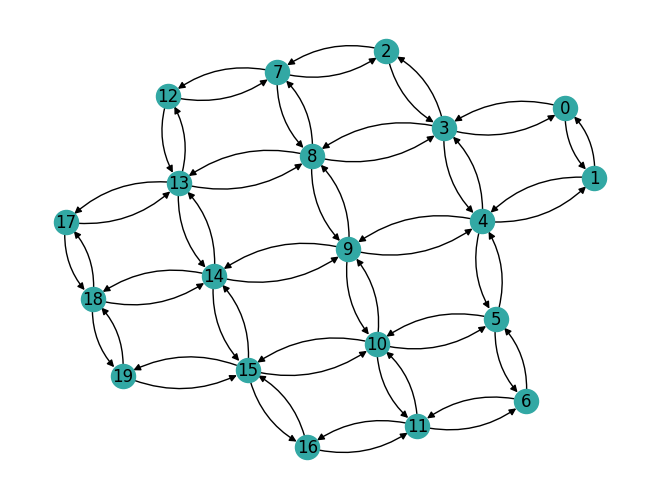

In [3]:
from rustworkx.visualization import mpl_draw
from rustworkx import spring_layout
from iqm.qiskit_iqm.fake_backends.fake_apollo import IQMFakeApollo

backend = IQMFakeApollo()
mpl_draw(backend.coupling_map.graph, arrows=True, with_labels=True, node_color='#32a8a4',
         pos=spring_layout(backend.coupling_map.graph, num_iter=200))

## Running the benchmark

In [4]:
benchmark_ghz = GHZBenchmark(backend, MINIMAL_GHZ)
run_ghz = benchmark_ghz.run()

2025-01-08 11:24:38,722 - iqm.benchmarks.logging_config - INFO - Now generating a 2-qubit GHZ state on qubits [18, 19]
2025-01-08 11:24:38,725 - iqm.benchmarks.logging_config - INFO - Transpiling for backend IQMFakeApolloBackend with optimization level 3, sabre routing method and SQG optimization all circuits
2025-01-08 11:24:39,589 - iqm.benchmarks.logging_config - INFO - Transpiling for backend IQMFakeApolloBackend with optimization level 3, sabre routing method and SQG optimization all circuits
2025-01-08 11:24:39,684 - iqm.benchmarks.logging_config - INFO - Submitting batch with 7 circuits corresponding to qubits [18, 19]
2025-01-08 11:24:39,702 - iqm.benchmarks.logging_config - INFO - Now generating a 3-qubit GHZ state on qubits [17, 18, 19]
2025-01-08 11:24:39,738 - iqm.benchmarks.logging_config - INFO - Transpiling for backend IQMFakeApolloBackend with optimization level 3, sabre routing method and SQG optimization all circuits
2025-01-08 11:24:39,933 - iqm.benchmarks.logging_co

In [5]:
result = benchmark_ghz.analyze()

## Accessing the results
To see individual fidelitiy and uncertainty values of a given qubit layout, one can filter the ``result.observations``-list by layout as shown below. 

The plot allows a comparison of all layout results with and without REM, where the data point description labels "L0", "L1", ... enumerate the layouts in the order defined in the configuration.

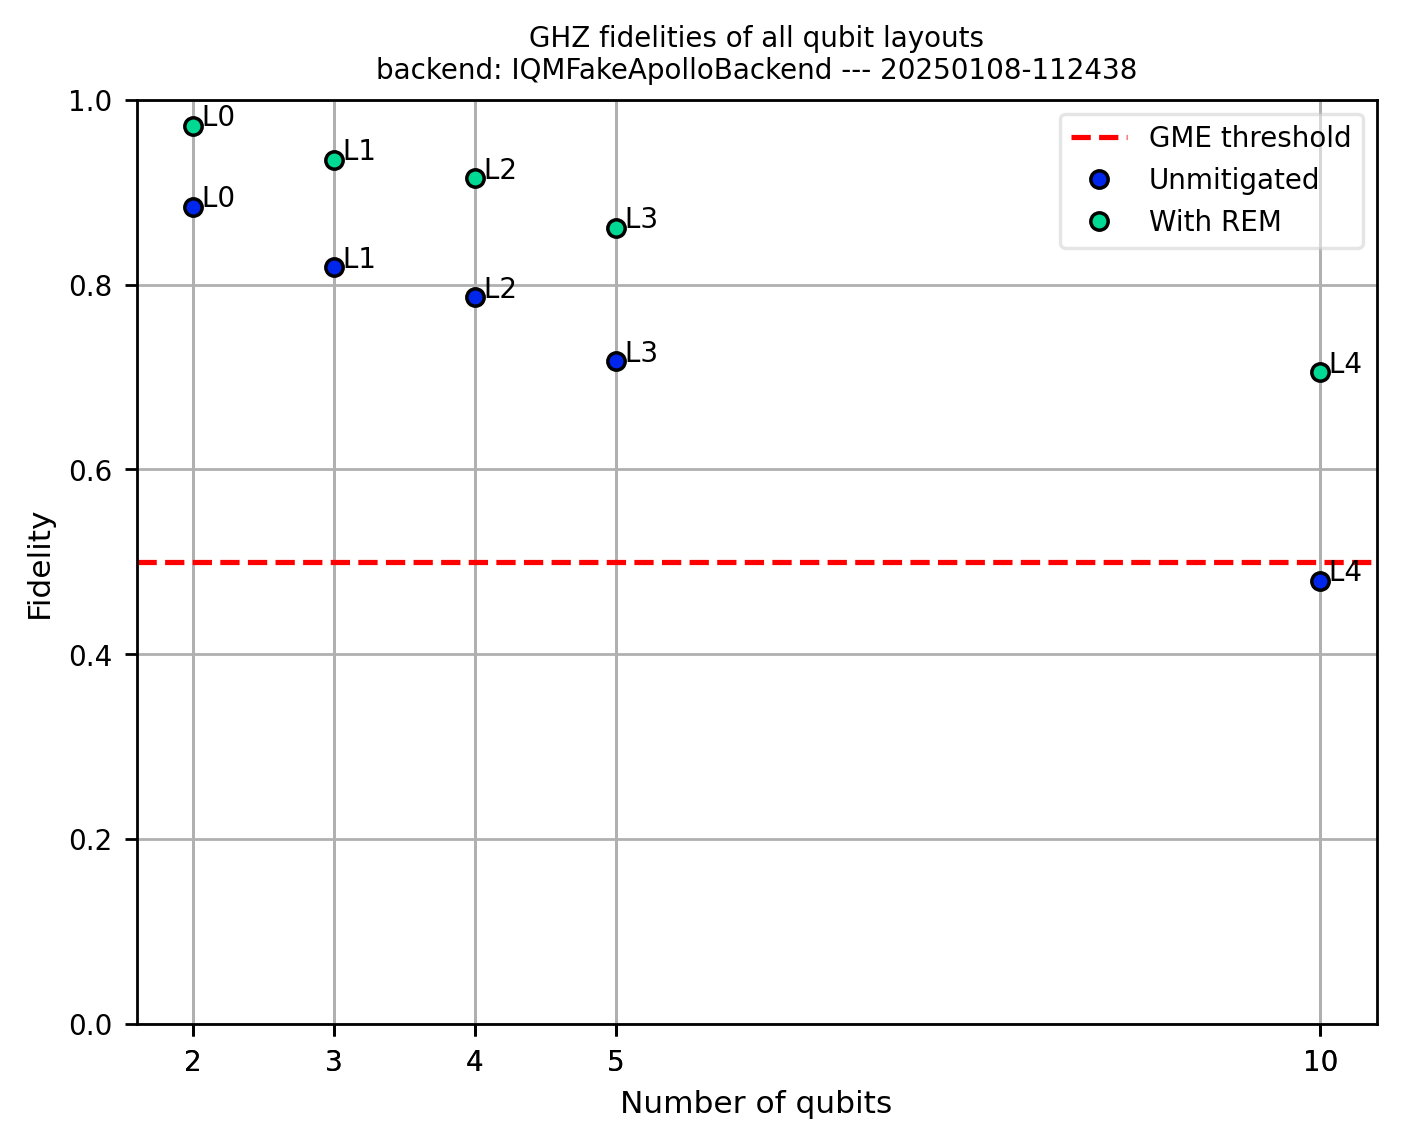

In [6]:
qubit_layout = [0,1,3]
for observation in result.observations:
    if observation.identifier.string_identifier == str(qubit_layout):
        print(f"{observation.name}: {observation.value} +/- {observation.uncertainty}")
result.plot_all()